# Variational Autoencoders - Aula Prática

## Configurações

Importando módulos necessários

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torchsummary import summary

## Introdução

Variational Autoencoders (VAEs) são uma classe de modelos generativos que são treinados para representar dados de entrada em um espaço latente de baixa dimensão. Eles são baseados em redes neurais e são treinados usando métodos de inferência variacional. VAEs são uma extensão de autoencoders tradicionais, que são usados para aprender representações compactas de dados de entrada. A principal diferença entre VAEs e autoencoders tradicionais é que VAEs são treinados para aprender a distribuição de probabilidade dos dados de entrada, enquanto autoencoders tradicionais são treinados para aprender uma função de mapeamento determinística dos dados de entrada para um espaço latente.

Nessa aula prática, vamos implementar um Variational Autoencoder para reconstruir imagens do dataset MNIST.

## Dataset

Vamos começar carregando o dataset MNIST. O dataset é composto por imagens de dígitos escritos à mão, com dimensões 28x28 pixels.

In [ ]:
"""
Como queremos que o autoencoder aprenda a reconstruir a imagem de entrada,
reformulamos o dataset MNIST para que ele retorne a mesma imagem como entrada e saída.
"""
class AutoencoderMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.MNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [ ]:
mnist_train_ds = AutoencoderMNIST(
    "./data/mnist",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    return_labels=True
)
mnist_test_ds = AutoencoderMNIST(
    "./data/mnist",
    train=False,
    transform=transforms.ToTensor()
)

print(
    "Tamanho do dataset de (treino, teste):", (len(mnist_train_ds), len(mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


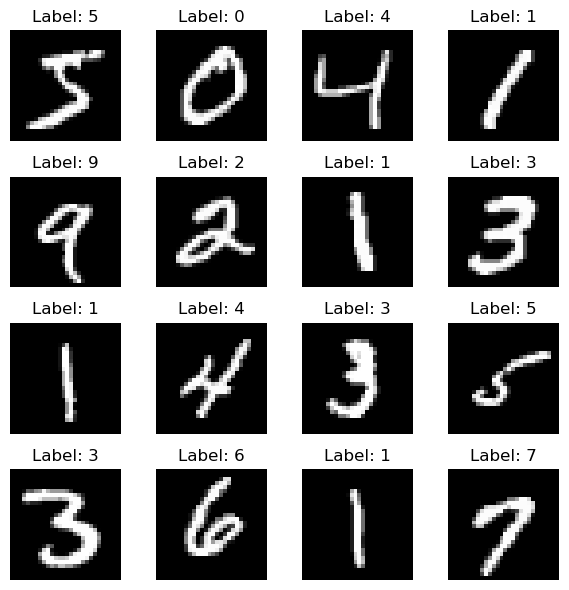

In [ ]:
# Plot the first 16 images from the MNIST dataset
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i == 0:
        print(f"image shape: {mnist_train_ds[i][0].shape}")
    image, _, label = mnist_train_ds[i]
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
    ax.set_title(f"Label: {label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Modelo

Como já mencionado, um VAE é composto por duas partes principais: um encoder e um decoder. O encoder é uma rede neural que mapeia os dados de entrada para um espaço latente de baixa dimensão, enquanto o decoder é uma rede neural que mapeia os pontos no espaço latente de volta para o espaço de entrada.

O principal da arquitetura já vimos na aula sobre Autoencoders tradicionais, mas a diferença é que o encoder de um VAE mapeia os dados de entrada para uma distribuição de probabilidade no espaço latente, em vez de mapear os dados de entrada para um ponto específico no espaço latente, como podemos ver na imagem abaixo:

O encder vai transformar os dados em $ \mu $ e $ \sigma $, que são os parâmetros da distribuição normal que representa o espaço latente, seguindo a fórmula:

$$ 
z = \mu + \sigma \cdot \epsilon 
$$

com $ \epsilon $ sendo uma amostra de uma distribuição normal padrão.

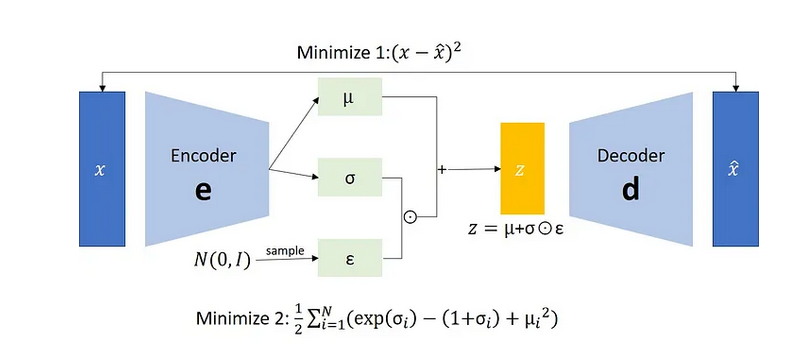

In [59]:
class VariationalConvolutionalEncoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(VariationalConvolutionalEncoder, self).__init__()
        self.latent_size = latent_size

        # reduzimos o tamanho da imagem
        # considerando input (n_channels, 28, 28)
        self.conv_layers = nn.Sequential(
            nn.Conv2d(n_channels, 16, 3, padding=1),  # (16, 28, 28)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (16, 14, 14)
            nn.Conv2d(16, 8, 3, padding=1),  # (8, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),  # (8, 7, 7)
            nn.Conv2d(8, 2, 3, padding=1),  # (2, 7, 7)
            nn.ReLU(),
        )

        # extraimos as features da imagem reduzida
        self.flatten = nn.Flatten()  # (2 * 7 * 7,) = (98,)

        # finalmente fazemos o encoding da nossa imagem em um vetor n dimensional
        self.z_log_sigma = nn.Linear(98, self.latent_size)
        self.z_mean = nn.Linear(98, self.latent_size)

    @property
    def device(self):
        return next(self.parameters()).device

    # função para amostrar a representação latente a partir da média e desvio padrão
    def sample(self, z_mean, z_log_sigma):
        epsilon = torch.normal(0, 0.1, z_mean.shape, device=self.device)
        return z_mean + torch.exp(z_log_sigma) * epsilon
    
    # função para calcular a divergência KL para a loss
    def kl_divergence(self):
        return -0.5 * torch.sum(1 + self.stdev - self.mean.pow(2) - self.stdev.exp())

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)

        # salvamos os valores de média e desvio padrão para serem usados na loss
        self.stdev = self.z_log_sigma(x)
        self.mean = self.z_mean(x)

        x = self.sample(self.mean, self.stdev)

        return x

In [60]:
# O decoder do VAE é o mesmo que o do AE
class ConvolutionalDecoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(ConvolutionalDecoder, self).__init__()
        self.latent_size = latent_size

        # decodificamos a representação latente para uma imagem 7x7
        self.decoder = nn.Linear(self.latent_size, 98)
        self.unflatten = nn.Unflatten(1, (2, 7, 7)) # (2, 7, 7)

        # voltamos a imagem ao tamanho original
        self.conv_layers = nn.Sequential(
            nn.Conv2d(2, 8, 3, padding=1), # (8, 7, 7)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (8, 14, 14)
            nn.Conv2d(8, 16, 3, padding=1), # (16, 14, 14)
            nn.ReLU(),
            nn.Upsample(scale_factor=2), # (16, 28, 28)
            nn.Conv2d(16, n_channels, 3, padding=1), # (n_channels, 28, 28)
            nn.Sigmoid(), # sigmoid na última camada para que o output esteja no intervalo [0, 1]
        )

    def forward(self, x):
        x = self.decoder(x)
        x = self.unflatten(x)
        x = self.conv_layers(x)
        return x

In [61]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_size=2, n_channels=3):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalConvolutionalEncoder(latent_size, n_channels)
        self.decoder = ConvolutionalDecoder(latent_size, n_channels)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VariationalAutoencoder(latent_size=2, n_channels=1)
vae = vae.to(device)
summary(vae, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
            Conv2d-7              [-1, 2, 7, 7]             146
              ReLU-8              [-1, 2, 7, 7]               0
           Flatten-9                   [-1, 98]               0
           Linear-10                    [-1, 2]             198
           Linear-11                    [-1, 2]             198
VariationalConvolutionalEncoder-12                    [-1, 2]               0
           Linear-13                   [-1, 98]             294
        Unflatten-14     

## Treinando o modelo

Vamos treinar o modelo para reconstruir imagens do dataset MNIST. O modelo será treinado por 20 épocas, com batch size 128 e otimizador Adam.

In [66]:
def loss_to_string(loss, prefix):
    return ' '.join([f'{prefix}_{l}: {loss[l]:.4f}' for l in loss])

def train(model, optimizer, loss_fn, train_loader, val_loader=None, device='cpu', epochs=32):
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_losses = {'loss': 0.0}

        for i, (inputs, targets) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader), unit='batch')):
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            # A loss é computada contra o input pois queremos reconstruir a imagem de entrada
            rec_loss = loss_fn(outputs, targets)
            rec_loss /= inputs.size(0)
            train_losses['rec_loss'] = train_losses.get('rec_loss', 0.0) + rec_loss.item()

            # Adicionamos a divergência KL à loss
            kl_loss = model.encoder.kl_divergence()
            kl_loss /= inputs.size(0)
            train_losses['kl_loss'] = train_losses.get('kl_loss', 0.0) + kl_loss.item()

            loss = rec_loss + kl_loss

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_losses['loss'] += loss.item()
            pbar.set_description(f"Epoch {epoch + 1}/{epochs} - Loss: {train_losses['loss']/(i+1):.4f}")

        for l in train_losses:
            train_losses[l] /= len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()
            val_losses = {'loss': 0.0}

            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)

                    outputs = model(inputs)
                    rec_loss = loss_fn(outputs, targets)
                    rec_loss /= inputs.size(0)
                    val_losses['rec_loss'] = val_losses.get('rec_loss', 0.0) + rec_loss.item()

                    kl_loss = model.encoder.kl_divergence()
                    kl_loss /= inputs.size(0)
                    val_losses['kl_loss'] = val_losses.get('kl_loss', 0.0) + kl_loss.item()

                    loss = rec_loss + kl_loss

                    val_losses['loss'] += loss.item()

            for l in val_losses:
                val_losses[l] /= len(val_loader)

            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(train_losses, 'train')} | {loss_to_string(val_losses, 'val')}")
        else:
            print(f"Epoch {epoch + 1}/{epochs}: {loss_to_string(train_losses, 'train')}")

In [95]:
vae = VariationalAutoencoder(latent_size=2, n_channels=1)

In [96]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [97]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 60.0110 train_rec_loss: 59.1490 train_kl_loss: 0.8620 | val_loss: 45.7659 val_rec_loss: 45.1231 val_kl_loss: 0.6427


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 44.2818 train_rec_loss: 43.7105 train_kl_loss: 0.5713 | val_loss: 43.4696 val_rec_loss: 42.9442 val_kl_loss: 0.5254


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 42.8518 train_rec_loss: 42.3288 train_kl_loss: 0.5230 | val_loss: 42.4157 val_rec_loss: 41.8957 val_kl_loss: 0.5200


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 42.0448 train_rec_loss: 41.5408 train_kl_loss: 0.5041 | val_loss: 41.7542 val_rec_loss: 41.2485 val_kl_loss: 0.5056


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 41.3335 train_rec_loss: 40.8218 train_kl_loss: 0.5117 | val_loss: 41.0836 val_rec_loss: 40.5303 val_kl_loss: 0.5533


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 40.7131 train_rec_loss: 40.1896 train_kl_loss: 0.5235 | val_loss: 40.5887 val_rec_loss: 40.0746 val_kl_loss: 0.5142


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 40.1851 train_rec_loss: 39.6502 train_kl_loss: 0.5350 | val_loss: 40.0110 val_rec_loss: 39.4590 val_kl_loss: 0.5520


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 39.7307 train_rec_loss: 39.1786 train_kl_loss: 0.5521 | val_loss: 39.6302 val_rec_loss: 39.0601 val_kl_loss: 0.5701


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 39.3356 train_rec_loss: 38.7755 train_kl_loss: 0.5601 | val_loss: 39.2008 val_rec_loss: 38.6306 val_kl_loss: 0.5702


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 39.0422 train_rec_loss: 38.4743 train_kl_loss: 0.5679 | val_loss: 39.0990 val_rec_loss: 38.5754 val_kl_loss: 0.5237


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 38.7856 train_rec_loss: 38.2150 train_kl_loss: 0.5707 | val_loss: 38.6733 val_rec_loss: 38.1077 val_kl_loss: 0.5657


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 38.6024 train_rec_loss: 38.0222 train_kl_loss: 0.5802 | val_loss: 38.5009 val_rec_loss: 37.9601 val_kl_loss: 0.5409


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 38.4383 train_rec_loss: 37.8571 train_kl_loss: 0.5812 | val_loss: 38.3369 val_rec_loss: 37.7766 val_kl_loss: 0.5603


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 38.2787 train_rec_loss: 37.6928 train_kl_loss: 0.5859 | val_loss: 38.1322 val_rec_loss: 37.5120 val_kl_loss: 0.6202


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 38.1203 train_rec_loss: 37.5265 train_kl_loss: 0.5938 | val_loss: 37.9685 val_rec_loss: 37.4129 val_kl_loss: 0.5556


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 37.9757 train_rec_loss: 37.3809 train_kl_loss: 0.5948 | val_loss: 37.8306 val_rec_loss: 37.2443 val_kl_loss: 0.5863


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 37.8584 train_rec_loss: 37.2587 train_kl_loss: 0.5997 | val_loss: 37.7950 val_rec_loss: 37.1652 val_kl_loss: 0.6298


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 37.7522 train_rec_loss: 37.1482 train_kl_loss: 0.6040 | val_loss: 37.7177 val_rec_loss: 37.0778 val_kl_loss: 0.6399


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 37.6717 train_rec_loss: 37.0656 train_kl_loss: 0.6060 | val_loss: 37.5524 val_rec_loss: 36.9379 val_kl_loss: 0.6146


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 37.6015 train_rec_loss: 36.9914 train_kl_loss: 0.6102 | val_loss: 37.5195 val_rec_loss: 36.9259 val_kl_loss: 0.5936


## Analisando os resultados

Nessa etapa, vamos analisar os resultados obtidos pelo autoencoder. Vamos visualizar as imagens de entrada e as imagens reconstruídas pelo autoencoder. Além disso, vamos visualizar a representação dos dados no espaço latente.

Loss for image 1: 27.334522247314453
Loss for image 2: 59.01725387573242
Loss for image 3: 6.183133125305176
Loss for image 4: 32.766929626464844
Loss for image 5: 27.59280776977539
Loss for image 6: 5.359182834625244
Loss for image 7: 40.559661865234375
Loss for image 8: 44.91315460205078


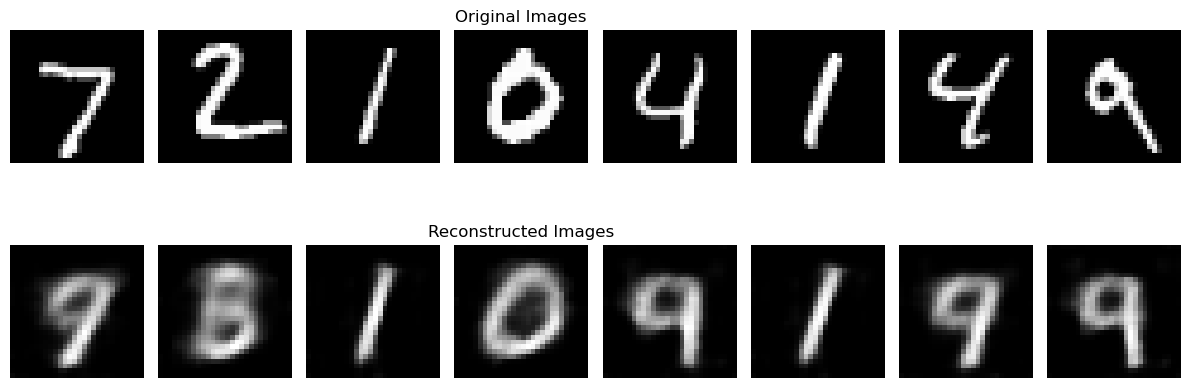

In [98]:
# Get some images from the test dataset
data_iter = iter(test_dl)
images, _ = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
vae.eval()
with torch.no_grad():
    reconstructions = vae(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(12, 5))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    # Reconstructed images
    ax = axes[1, i]
    ax.imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images')

    loss = criterion(reconstructions[i], images[i])
    print(f"Loss for image {i+1}: {loss.item()}")

plt.tight_layout()
plt.show()

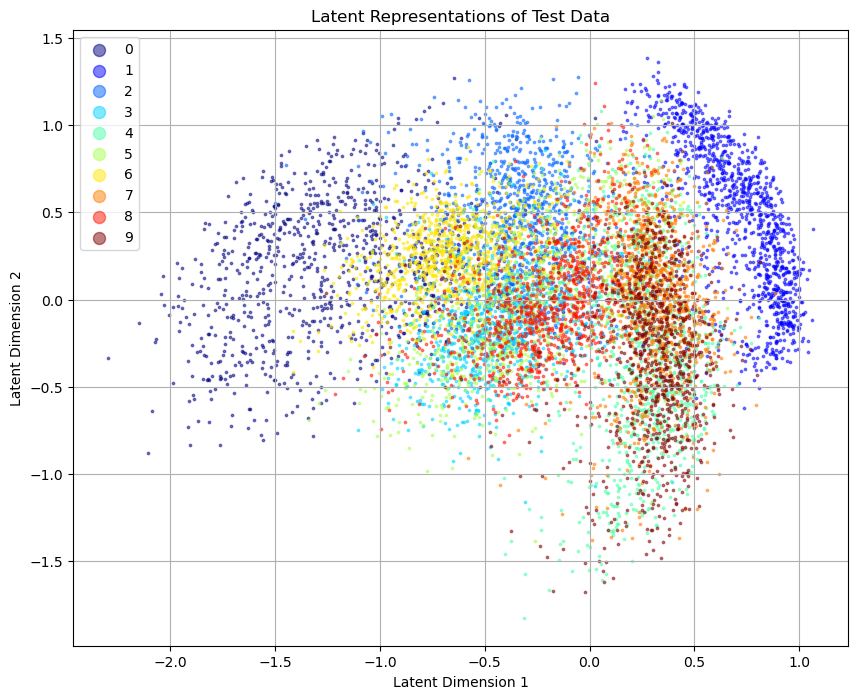

In [99]:
# Get the latent representations for all test data
latent_representations = []
labels_agg = []
digits = list(range(10))

mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(mnist_test_ds, batch_size=128)

vae.eval()
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = vae.encoder(images)
        latent_representations.append(latent_vectors.cpu().numpy())
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations = np.concatenate(latent_representations, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
plt.figure(figsize=(10, 8))
cmap = plt.get_cmap('jet', 10)
for d in digits:
    indices = np.where(labels_agg == d)
    plt.scatter(
        latent_representations[indices, 0],
        latent_representations[indices, 1],
        s=3,
        label=f"{d}",
        c=[cmap(d)],
        alpha=0.5,
    )
# add the labels mapping
plt.legend(markerscale=5)
plt.title('Latent Representations of Test Data')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.grid(True)
plt.show()

É interessante observar na distribuição dos dados no em comparação com com o observado no resultado do Autoencoder tradicional é que o Autoencoder Variacional distribui os dados no espaço latente tentando seguir uma distribuição normal padrão.

# Exercícios

## Exercício 1

Teste o autoencoder variacional com mais dimensionalidades no espaço latente. Tente com 5, 20 e 50 dimensões. Compare os resultados obtidos.

<details>
<summary>Dica:</summary>

Para visualizar a representação dos dados no espaço latente, utilize um [t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) para reduzir a dimensionalidade dos dados para 2 dimensões.

</details>

In [109]:
vae2 = VariationalAutoencoder(latent_size=2, n_channels=1)
vae5 = VariationalAutoencoder(latent_size=5, n_channels=1)
vae20 = VariationalAutoencoder(latent_size=20, n_channels=1)
vae50 = VariationalAutoencoder(latent_size=50, n_channels=1)

In [110]:
mnist_train_ds.stop_return_labels()
mnist_test_ds.stop_return_labels()
train_dl = DataLoader(mnist_train_ds, batch_size=128, shuffle=True)
test_dl = DataLoader(mnist_test_ds, batch_size=128)

In [111]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae2.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae2, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 63.3815 train_rec_loss: 61.9813 train_kl_loss: 1.4002 | val_loss: 45.7992 val_rec_loss: 45.2011 val_kl_loss: 0.5981


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 44.3384 train_rec_loss: 43.7863 train_kl_loss: 0.5521 | val_loss: 43.3898 val_rec_loss: 42.8749 val_kl_loss: 0.5148


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 42.7794 train_rec_loss: 42.2660 train_kl_loss: 0.5134 | val_loss: 42.2986 val_rec_loss: 41.7802 val_kl_loss: 0.5183


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 41.9589 train_rec_loss: 41.4537 train_kl_loss: 0.5052 | val_loss: 41.6706 val_rec_loss: 41.1282 val_kl_loss: 0.5424


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 41.3293 train_rec_loss: 40.8205 train_kl_loss: 0.5087 | val_loss: 41.0800 val_rec_loss: 40.5736 val_kl_loss: 0.5065


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 40.7162 train_rec_loss: 40.1934 train_kl_loss: 0.5228 | val_loss: 40.4147 val_rec_loss: 39.8903 val_kl_loss: 0.5244


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 40.1445 train_rec_loss: 39.6055 train_kl_loss: 0.5389 | val_loss: 39.8215 val_rec_loss: 39.2961 val_kl_loss: 0.5254


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 39.6404 train_rec_loss: 39.0862 train_kl_loss: 0.5542 | val_loss: 39.5138 val_rec_loss: 38.9349 val_kl_loss: 0.5789


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 39.2168 train_rec_loss: 38.6452 train_kl_loss: 0.5717 | val_loss: 38.9838 val_rec_loss: 38.4044 val_kl_loss: 0.5794


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 38.8686 train_rec_loss: 38.2799 train_kl_loss: 0.5887 | val_loss: 38.6707 val_rec_loss: 38.0947 val_kl_loss: 0.5760


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 38.5814 train_rec_loss: 37.9777 train_kl_loss: 0.6037 | val_loss: 38.3487 val_rec_loss: 37.7786 val_kl_loss: 0.5701


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 38.3580 train_rec_loss: 37.7472 train_kl_loss: 0.6108 | val_loss: 38.2609 val_rec_loss: 37.6431 val_kl_loss: 0.6178


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 38.1343 train_rec_loss: 37.5128 train_kl_loss: 0.6215 | val_loss: 37.9262 val_rec_loss: 37.3035 val_kl_loss: 0.6226


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 37.9727 train_rec_loss: 37.3442 train_kl_loss: 0.6286 | val_loss: 37.8260 val_rec_loss: 37.2136 val_kl_loss: 0.6123


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 37.8237 train_rec_loss: 37.1922 train_kl_loss: 0.6315 | val_loss: 37.6985 val_rec_loss: 37.0907 val_kl_loss: 0.6078


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 37.6979 train_rec_loss: 37.0640 train_kl_loss: 0.6339 | val_loss: 37.5849 val_rec_loss: 36.9093 val_kl_loss: 0.6756


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 37.6105 train_rec_loss: 36.9651 train_kl_loss: 0.6455 | val_loss: 37.4767 val_rec_loss: 36.8305 val_kl_loss: 0.6461


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 37.5176 train_rec_loss: 36.8683 train_kl_loss: 0.6493 | val_loss: 37.4773 val_rec_loss: 36.8241 val_kl_loss: 0.6532


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 37.4384 train_rec_loss: 36.7881 train_kl_loss: 0.6502 | val_loss: 37.3502 val_rec_loss: 36.6777 val_kl_loss: 0.6725


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 37.3735 train_rec_loss: 36.7241 train_kl_loss: 0.6495 | val_loss: 37.3255 val_rec_loss: 36.6971 val_kl_loss: 0.6285


In [112]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae5.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae5, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 56.4487 train_rec_loss: 55.3882 train_kl_loss: 1.0605 | val_loss: 37.3603 val_rec_loss: 36.4500 val_kl_loss: 0.9103


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 34.8700 train_rec_loss: 33.9164 train_kl_loss: 0.9536 | val_loss: 33.0535 val_rec_loss: 32.0813 val_kl_loss: 0.9722


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 32.5500 train_rec_loss: 31.5605 train_kl_loss: 0.9895 | val_loss: 31.8353 val_rec_loss: 30.8569 val_kl_loss: 0.9784


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 31.4514 train_rec_loss: 30.4505 train_kl_loss: 1.0009 | val_loss: 30.7469 val_rec_loss: 29.7376 val_kl_loss: 1.0093


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 30.7118 train_rec_loss: 29.7078 train_kl_loss: 1.0040 | val_loss: 30.1386 val_rec_loss: 29.1522 val_kl_loss: 0.9863


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 30.1094 train_rec_loss: 29.0991 train_kl_loss: 1.0103 | val_loss: 29.7581 val_rec_loss: 28.7046 val_kl_loss: 1.0535


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 29.5946 train_rec_loss: 28.5845 train_kl_loss: 1.0101 | val_loss: 29.1990 val_rec_loss: 28.1878 val_kl_loss: 1.0111


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 29.1468 train_rec_loss: 28.1219 train_kl_loss: 1.0249 | val_loss: 28.6527 val_rec_loss: 27.6530 val_kl_loss: 0.9996


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 28.7722 train_rec_loss: 27.7433 train_kl_loss: 1.0289 | val_loss: 28.3844 val_rec_loss: 27.3606 val_kl_loss: 1.0238


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 28.5065 train_rec_loss: 27.4760 train_kl_loss: 1.0306 | val_loss: 28.1881 val_rec_loss: 27.2133 val_kl_loss: 0.9748


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 28.2787 train_rec_loss: 27.2400 train_kl_loss: 1.0387 | val_loss: 27.9749 val_rec_loss: 26.9398 val_kl_loss: 1.0351


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 28.0761 train_rec_loss: 27.0354 train_kl_loss: 1.0407 | val_loss: 27.9022 val_rec_loss: 26.8321 val_kl_loss: 1.0701


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 27.9004 train_rec_loss: 26.8551 train_kl_loss: 1.0454 | val_loss: 27.7188 val_rec_loss: 26.6812 val_kl_loss: 1.0376


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 27.7357 train_rec_loss: 26.6855 train_kl_loss: 1.0502 | val_loss: 27.5219 val_rec_loss: 26.4058 val_kl_loss: 1.1162


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 27.6090 train_rec_loss: 26.5518 train_kl_loss: 1.0572 | val_loss: 27.4649 val_rec_loss: 26.3869 val_kl_loss: 1.0780


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 27.4998 train_rec_loss: 26.4396 train_kl_loss: 1.0602 | val_loss: 27.2827 val_rec_loss: 26.2181 val_kl_loss: 1.0646


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 27.4058 train_rec_loss: 26.3442 train_kl_loss: 1.0616 | val_loss: 27.2387 val_rec_loss: 26.1812 val_kl_loss: 1.0575


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 27.3229 train_rec_loss: 26.2608 train_kl_loss: 1.0620 | val_loss: 27.0824 val_rec_loss: 26.0237 val_kl_loss: 1.0587


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 27.2517 train_rec_loss: 26.1854 train_kl_loss: 1.0663 | val_loss: 27.0379 val_rec_loss: 25.9614 val_kl_loss: 1.0765


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 27.1895 train_rec_loss: 26.1215 train_kl_loss: 1.0680 | val_loss: 27.0567 val_rec_loss: 25.9986 val_kl_loss: 1.0581


In [118]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae20.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae20, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 50.9378 train_rec_loss: 49.4249 train_kl_loss: 1.5129 | val_loss: 25.3296 val_rec_loss: 23.3844 val_kl_loss: 1.9452


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 21.5004 train_rec_loss: 19.4815 train_kl_loss: 2.0190 | val_loss: 18.5629 val_rec_loss: 16.4343 val_kl_loss: 2.1287


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 17.6707 train_rec_loss: 15.5791 train_kl_loss: 2.0916 | val_loss: 16.3788 val_rec_loss: 14.2606 val_kl_loss: 2.1182


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 16.0342 train_rec_loss: 13.9402 train_kl_loss: 2.0940 | val_loss: 15.1520 val_rec_loss: 13.0250 val_kl_loss: 2.1270


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 15.1505 train_rec_loss: 13.0569 train_kl_loss: 2.0936 | val_loss: 14.4916 val_rec_loss: 12.4723 val_kl_loss: 2.0193


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 14.5587 train_rec_loss: 12.4614 train_kl_loss: 2.0973 | val_loss: 13.9843 val_rec_loss: 11.8983 val_kl_loss: 2.0861


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 14.1513 train_rec_loss: 12.0460 train_kl_loss: 2.1053 | val_loss: 13.6665 val_rec_loss: 11.5292 val_kl_loss: 2.1374


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 13.8440 train_rec_loss: 11.7333 train_kl_loss: 2.1107 | val_loss: 13.3484 val_rec_loss: 11.2516 val_kl_loss: 2.0968


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 13.6070 train_rec_loss: 11.4848 train_kl_loss: 2.1222 | val_loss: 13.2032 val_rec_loss: 11.1172 val_kl_loss: 2.0860


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 13.4236 train_rec_loss: 11.2960 train_kl_loss: 2.1276 | val_loss: 13.0474 val_rec_loss: 10.9257 val_kl_loss: 2.1217


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 13.2825 train_rec_loss: 11.1463 train_kl_loss: 2.1362 | val_loss: 12.8867 val_rec_loss: 10.7692 val_kl_loss: 2.1175


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 13.1150 train_rec_loss: 10.9786 train_kl_loss: 2.1364 | val_loss: 12.8267 val_rec_loss: 10.7073 val_kl_loss: 2.1194


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 12.9955 train_rec_loss: 10.8534 train_kl_loss: 2.1421 | val_loss: 12.6315 val_rec_loss: 10.4934 val_kl_loss: 2.1381


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 12.9109 train_rec_loss: 10.7595 train_kl_loss: 2.1514 | val_loss: 12.5292 val_rec_loss: 10.3836 val_kl_loss: 2.1456


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 12.7805 train_rec_loss: 10.6229 train_kl_loss: 2.1576 | val_loss: 12.3863 val_rec_loss: 10.2865 val_kl_loss: 2.0998


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 12.7010 train_rec_loss: 10.5364 train_kl_loss: 2.1646 | val_loss: 12.4700 val_rec_loss: 10.2983 val_kl_loss: 2.1717


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 12.6307 train_rec_loss: 10.4588 train_kl_loss: 2.1719 | val_loss: 12.2921 val_rec_loss: 10.1374 val_kl_loss: 2.1548


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 12.5342 train_rec_loss: 10.3631 train_kl_loss: 2.1711 | val_loss: 12.2206 val_rec_loss: 10.0768 val_kl_loss: 2.1438


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 12.4693 train_rec_loss: 10.2922 train_kl_loss: 2.1771 | val_loss: 12.1922 val_rec_loss: 10.0248 val_kl_loss: 2.1674


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 12.4131 train_rec_loss: 10.2352 train_kl_loss: 2.1779 | val_loss: 12.1098 val_rec_loss: 10.0065 val_kl_loss: 2.1032


In [119]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(vae50.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(vae50, optimizer, criterion, train_dl, test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 44.1418 train_rec_loss: 41.9416 train_kl_loss: 2.2001 | val_loss: 19.6498 val_rec_loss: 17.1270 val_kl_loss: 2.5227


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 17.1037 train_rec_loss: 14.6702 train_kl_loss: 2.4335 | val_loss: 14.9985 val_rec_loss: 12.5855 val_kl_loss: 2.4130


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 14.3442 train_rec_loss: 11.8872 train_kl_loss: 2.4570 | val_loss: 13.2173 val_rec_loss: 10.7465 val_kl_loss: 2.4709


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 13.0496 train_rec_loss: 10.5901 train_kl_loss: 2.4595 | val_loss: 12.2413 val_rec_loss: 9.7310 val_kl_loss: 2.5103


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 12.2245 train_rec_loss: 9.7493 train_kl_loss: 2.4752 | val_loss: 11.6563 val_rec_loss: 9.1555 val_kl_loss: 2.5008


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 11.6287 train_rec_loss: 9.1306 train_kl_loss: 2.4982 | val_loss: 11.1409 val_rec_loss: 8.6851 val_kl_loss: 2.4558


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 11.1883 train_rec_loss: 8.6684 train_kl_loss: 2.5200 | val_loss: 10.8132 val_rec_loss: 8.2934 val_kl_loss: 2.5199


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 10.8515 train_rec_loss: 8.3123 train_kl_loss: 2.5391 | val_loss: 10.4803 val_rec_loss: 7.8639 val_kl_loss: 2.6164


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 10.5797 train_rec_loss: 8.0247 train_kl_loss: 2.5550 | val_loss: 10.1979 val_rec_loss: 7.6953 val_kl_loss: 2.5026


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 10.3755 train_rec_loss: 7.8144 train_kl_loss: 2.5611 | val_loss: 10.1071 val_rec_loss: 7.5102 val_kl_loss: 2.5969


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 10.1871 train_rec_loss: 7.6125 train_kl_loss: 2.5746 | val_loss: 9.9103 val_rec_loss: 7.3379 val_kl_loss: 2.5723


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 10.0309 train_rec_loss: 7.4491 train_kl_loss: 2.5818 | val_loss: 9.7768 val_rec_loss: 7.1914 val_kl_loss: 2.5853


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 9.9281 train_rec_loss: 7.3403 train_kl_loss: 2.5878 | val_loss: 9.6570 val_rec_loss: 7.1005 val_kl_loss: 2.5565


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 9.8017 train_rec_loss: 7.2094 train_kl_loss: 2.5923 | val_loss: 9.5951 val_rec_loss: 6.9736 val_kl_loss: 2.6215


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 9.7191 train_rec_loss: 7.1191 train_kl_loss: 2.5999 | val_loss: 9.4850 val_rec_loss: 6.8697 val_kl_loss: 2.6153


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 9.5982 train_rec_loss: 7.0055 train_kl_loss: 2.5926 | val_loss: 9.3630 val_rec_loss: 6.7673 val_kl_loss: 2.5957


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 9.5142 train_rec_loss: 6.9155 train_kl_loss: 2.5987 | val_loss: 9.2741 val_rec_loss: 6.6810 val_kl_loss: 2.5931


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 9.4260 train_rec_loss: 6.8294 train_kl_loss: 2.5967 | val_loss: 9.1998 val_rec_loss: 6.5798 val_kl_loss: 2.6200


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 9.3495 train_rec_loss: 6.7540 train_kl_loss: 2.5955 | val_loss: 9.1294 val_rec_loss: 6.6300 val_kl_loss: 2.4993


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 9.2818 train_rec_loss: 6.6828 train_kl_loss: 2.5990 | val_loss: 9.1216 val_rec_loss: 6.5566 val_kl_loss: 2.5650


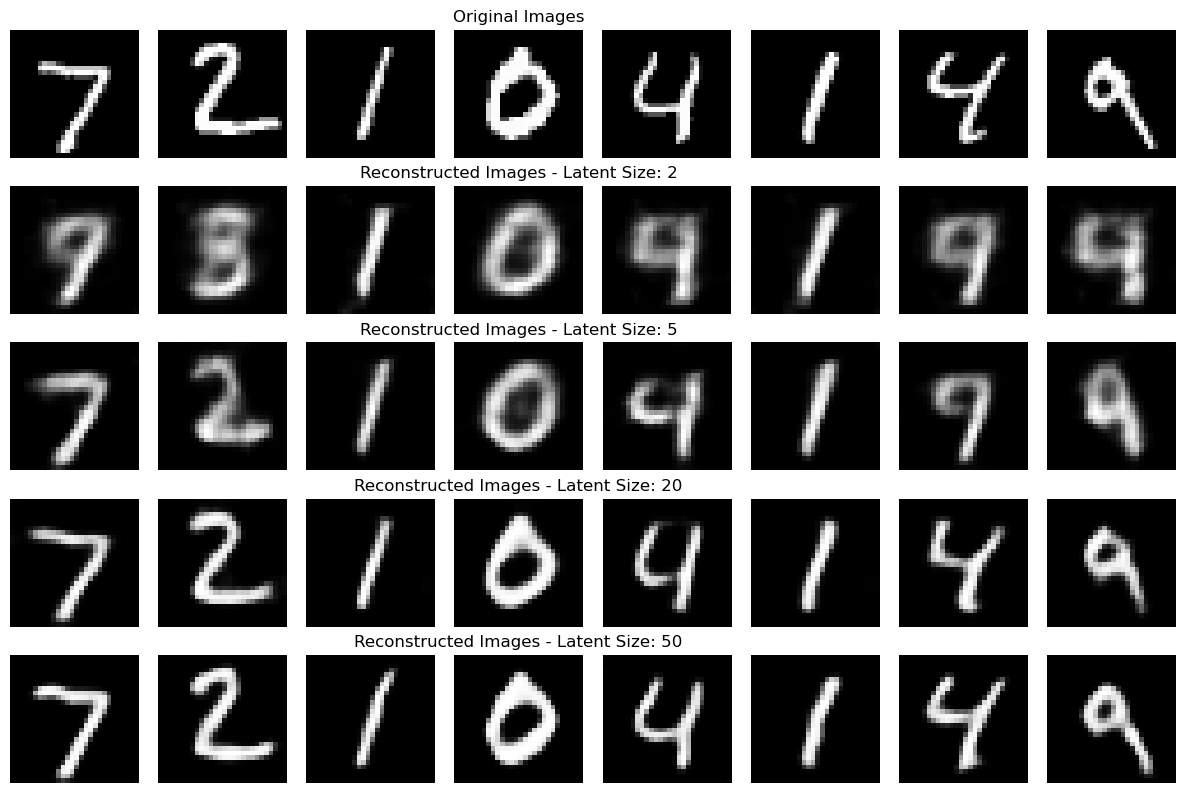

In [128]:
# Get some images from the test dataset
data_iter = iter(test_dl)
images, _ = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
vae2.eval()
vae5.eval()
vae20.eval()
vae50.eval()
with torch.no_grad():
    reconstructions_2 = vae2(images)
    reconstructions_5 = vae5(images)
    reconstructions_20 = vae20(images)
    reconstructions_50 = vae50(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(5, 8, figsize=(12, 8))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    ax = axes[1, i]
    ax.imshow(reconstructions_2[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 2')

    ax = axes[2, i]
    ax.imshow(reconstructions_5[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 5')

    ax = axes[3, i]
    ax.imshow(reconstructions_20[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 20')

    ax = axes[4, i]
    ax.imshow(reconstructions_50[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 50')

plt.tight_layout()
plt.show()

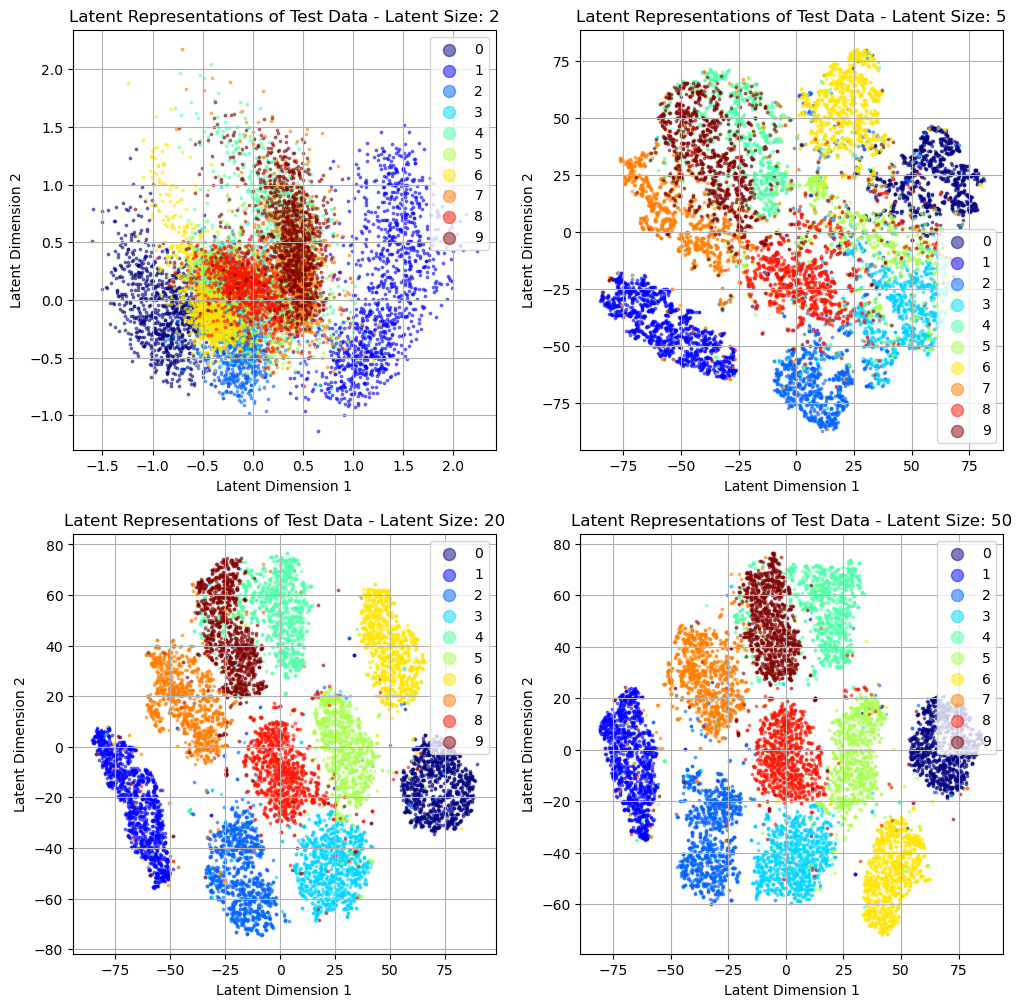

In [130]:
from sklearn.manifold import TSNE

latent_representations_2 = []
latent_representations_5 = []
latent_representations_20 = []
latent_representations_50 = []
labels_agg = []
digits = list(range(10))

mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(mnist_test_ds, batch_size=128)

vae.eval()
vae2.eval()
vae5.eval()
vae20.eval()
vae50.eval()
# Get the latent representations for all test data
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = vae2.encoder(images)
        latent_representations_2.append(latent_vectors.cpu().numpy())
        latent_vectors = vae5.encoder(images)
        latent_representations_5.append(latent_vectors.cpu().numpy()) 
        latent_vectors = vae20.encoder(images)
        latent_representations_20.append(latent_vectors.cpu().numpy()) 
        latent_vectors = vae50.encoder(images)
        latent_representations_50.append(latent_vectors.cpu().numpy()) 
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations_2 = np.concatenate(latent_representations_2, axis=0)
latent_representations_5 = np.concatenate(latent_representations_5, axis=0)
latent_representations_20 = np.concatenate(latent_representations_20, axis=0)
latent_representations_50 = np.concatenate(latent_representations_50, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
cmap = plt.get_cmap('jet', 10)
for i, (representation, n_dims) in enumerate(zip([latent_representations_2, latent_representations_5, latent_representations_20, latent_representations_50], [2, 5, 20, 50])):
    # Create a 2D representation of the latent space
    if n_dims == 2:
        X_embedded = representation
    else:
        X_embedded = TSNE(n_components=2).fit_transform(representation)

    # Plot the 2D representation
    ax = axes[i // 2, i % 2]
    for d in digits:
        indices = np.where(labels_agg == d)
        
        ax.scatter(
            X_embedded[indices, 0],
            X_embedded[indices, 1],
            s=3,
            label=f"{d}",
            c=[cmap(d)],
            alpha=0.5,
        )
    ax.legend(markerscale=5)
    ax.set_title(f'Latent Representations of Test Data - Latent Size: {n_dims}')
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)
plt.show()

## Exercício 2

Teste o autoencoder variacional no dataset Fashion MNIST. Compare os resultados obtidos com o dataset MNIST. Teste com diferentes dimensionalidades no espaço latente e tente encontrar a menor dimensionalidade que ainda consegue reconstruir as imagens de forma satisfatória.

<details>
<summary>Dica:</summary>

O autoencoder fornecido talvez seja muito simples para o dataset Fashion MNIST. Tente aumentar a complexidade do modelo.

</details>

In [131]:
class AutoencoderFaishonMNIST(torch.utils.data.Dataset):
    def __init__(self, root, train=True, transform=None, input_transform=None, target_transform=None, download=False, return_labels=False):
        self.dataset = datasets.FashionMNIST(root=root, train=train, transform=transform, download=download)
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.return_labels = return_labels

    def __getitem__(self, idx):
        x, label = self.dataset[idx]
        y = x.clone()

        if self.input_transform:
            x = self.input_transform(x)
        if self.target_transform:
            y = self.target_transform(y)

        return (x, y, label) if self.return_labels else (x, y)
    
    def start_return_labels(self):
        self.return_labels = True
    
    def stop_return_labels(self):
        self.return_labels = False

    def __len__(self):
        return len(self.dataset)

In [164]:
from sklearn.preprocessing import LabelEncoder

class FaishonMnistLabelMapper(object):
    def __init__(self):
        self.mapping = {
            0: 'T-shirt/top',
            1: 'Trouser',
            2: 'Pullover',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot'
        }

        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(list(self.mapping.values()))
    
    def __getitem__(self, label):
        return self.mapping[label]
    
    def __call__(self, label):
        return self.label_encoder.inverse_transform([label] if isinstance(label, int) else label)

label_mapper = FaishonMnistLabelMapper()

In [170]:
faishon_mnist_train_ds = AutoencoderFaishonMNIST(
    "./data/fmnist",
    train=True,
    transform=transforms.ToTensor(),
    download=True,
    return_labels=True
)
faishon_mnist_test_ds = AutoencoderFaishonMNIST(
    "./data/fmnist",
    train=False,
    transform=transforms.ToTensor()
)

print(
    "Tamanho do dataset de (treino, teste):", (len(faishon_mnist_train_ds), len(faishon_mnist_test_ds))
)

Tamanho do dataset de (treino, teste): (60000, 10000)


image shape: torch.Size([1, 28, 28])


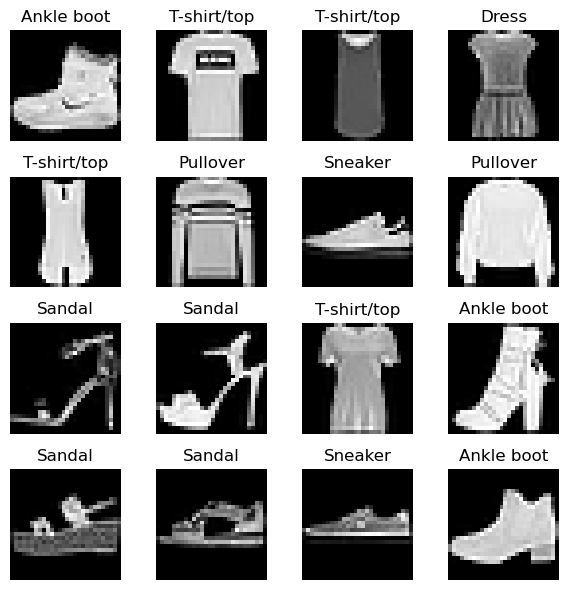

In [171]:
# Plot the first 16 images from the MNIST dataset
fig, axes = plt.subplots(4, 4, figsize=(6, 6))

for i, ax in enumerate(axes.flat):
    if i == 0:
        print(f"image shape: {faishon_mnist_train_ds[i][0].shape}")
    image, _, label = faishon_mnist_train_ds[i]
    label = label_mapper[label]
    ax.imshow(image.squeeze(), cmap="gray")  # Squeeze removes the channel dimension
    ax.set_title(f"{label}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [178]:
fvae_2 = VariationalAutoencoder(latent_size=2, n_channels=1)
fvae_5 = VariationalAutoencoder(latent_size=5, n_channels=1)
fvae_20 = VariationalAutoencoder(latent_size=20, n_channels=1)
fvae_50 = VariationalAutoencoder(latent_size=50, n_channels=1)

In [179]:
faishon_mnist_train_ds.stop_return_labels()
faishon_mnist_test_ds.stop_return_labels()
faishon_train_dl = DataLoader(faishon_mnist_train_ds, batch_size=128, shuffle=True)
faishon_test_dl = DataLoader(faishon_mnist_test_ds, batch_size=128)

In [180]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_2.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_2, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 54.3747 train_rec_loss: 52.9881 train_kl_loss: 1.3866 | val_loss: 35.8333 val_rec_loss: 34.5931 val_kl_loss: 1.2401


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 34.4596 train_rec_loss: 33.3635 train_kl_loss: 1.0961 | val_loss: 33.6581 val_rec_loss: 32.6061 val_kl_loss: 1.0520


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 32.8622 train_rec_loss: 31.8308 train_kl_loss: 1.0314 | val_loss: 32.2595 val_rec_loss: 31.2471 val_kl_loss: 1.0123


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 31.8327 train_rec_loss: 30.8229 train_kl_loss: 1.0098 | val_loss: 31.4181 val_rec_loss: 30.4074 val_kl_loss: 1.0107


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 31.1170 train_rec_loss: 30.1108 train_kl_loss: 1.0062 | val_loss: 30.7686 val_rec_loss: 29.8076 val_kl_loss: 0.9609


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 30.6032 train_rec_loss: 29.6049 train_kl_loss: 0.9984 | val_loss: 30.4236 val_rec_loss: 29.4351 val_kl_loss: 0.9885


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 30.2240 train_rec_loss: 29.2230 train_kl_loss: 1.0010 | val_loss: 29.9927 val_rec_loss: 29.0193 val_kl_loss: 0.9733


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 29.9233 train_rec_loss: 28.9292 train_kl_loss: 0.9940 | val_loss: 29.7930 val_rec_loss: 28.7660 val_kl_loss: 1.0270


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 29.6437 train_rec_loss: 28.6512 train_kl_loss: 0.9925 | val_loss: 29.3794 val_rec_loss: 28.3826 val_kl_loss: 0.9968


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 29.3961 train_rec_loss: 28.4113 train_kl_loss: 0.9848 | val_loss: 29.2673 val_rec_loss: 28.2736 val_kl_loss: 0.9937


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 29.2100 train_rec_loss: 28.2270 train_kl_loss: 0.9831 | val_loss: 29.0042 val_rec_loss: 28.0360 val_kl_loss: 0.9681


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 29.0113 train_rec_loss: 28.0304 train_kl_loss: 0.9809 | val_loss: 28.8811 val_rec_loss: 27.8990 val_kl_loss: 0.9821


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 28.8609 train_rec_loss: 27.8900 train_kl_loss: 0.9709 | val_loss: 28.6816 val_rec_loss: 27.7065 val_kl_loss: 0.9751


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 28.7327 train_rec_loss: 27.7650 train_kl_loss: 0.9677 | val_loss: 28.6737 val_rec_loss: 27.7333 val_kl_loss: 0.9404


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 28.6035 train_rec_loss: 27.6403 train_kl_loss: 0.9632 | val_loss: 28.6191 val_rec_loss: 27.6299 val_kl_loss: 0.9892


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 28.5118 train_rec_loss: 27.5518 train_kl_loss: 0.9599 | val_loss: 28.4196 val_rec_loss: 27.4642 val_kl_loss: 0.9554


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 28.3933 train_rec_loss: 27.4388 train_kl_loss: 0.9546 | val_loss: 28.2581 val_rec_loss: 27.2577 val_kl_loss: 1.0005


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 28.3109 train_rec_loss: 27.3599 train_kl_loss: 0.9509 | val_loss: 28.2069 val_rec_loss: 27.2294 val_kl_loss: 0.9775


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 28.2120 train_rec_loss: 27.2630 train_kl_loss: 0.9491 | val_loss: 28.1273 val_rec_loss: 27.2074 val_kl_loss: 0.9199


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 28.1614 train_rec_loss: 27.2108 train_kl_loss: 0.9507 | val_loss: 28.2037 val_rec_loss: 27.2747 val_kl_loss: 0.9290


In [181]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_5.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_5, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 47.1194 train_rec_loss: 45.7122 train_kl_loss: 1.4072 | val_loss: 27.5538 val_rec_loss: 26.1668 val_kl_loss: 1.3870


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 25.3727 train_rec_loss: 24.0162 train_kl_loss: 1.3565 | val_loss: 23.9673 val_rec_loss: 22.6624 val_kl_loss: 1.3048


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 23.2935 train_rec_loss: 21.9977 train_kl_loss: 1.2957 | val_loss: 22.7840 val_rec_loss: 21.5145 val_kl_loss: 1.2694


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 22.3907 train_rec_loss: 21.1165 train_kl_loss: 1.2742 | val_loss: 22.0866 val_rec_loss: 20.8008 val_kl_loss: 1.2858


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 21.7827 train_rec_loss: 20.5228 train_kl_loss: 1.2598 | val_loss: 21.5892 val_rec_loss: 20.4071 val_kl_loss: 1.1820


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 21.3420 train_rec_loss: 20.0885 train_kl_loss: 1.2535 | val_loss: 21.1567 val_rec_loss: 19.9631 val_kl_loss: 1.1936


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 20.9316 train_rec_loss: 19.6953 train_kl_loss: 1.2363 | val_loss: 20.8411 val_rec_loss: 19.6794 val_kl_loss: 1.1617


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 20.5978 train_rec_loss: 19.3790 train_kl_loss: 1.2188 | val_loss: 20.6224 val_rec_loss: 19.3697 val_kl_loss: 1.2527


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 20.3646 train_rec_loss: 19.1574 train_kl_loss: 1.2072 | val_loss: 20.4749 val_rec_loss: 19.2791 val_kl_loss: 1.1958


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 20.1752 train_rec_loss: 18.9794 train_kl_loss: 1.1957 | val_loss: 20.3144 val_rec_loss: 19.1061 val_kl_loss: 1.2083


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 20.0151 train_rec_loss: 18.8264 train_kl_loss: 1.1887 | val_loss: 20.1572 val_rec_loss: 18.9919 val_kl_loss: 1.1653


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 19.8837 train_rec_loss: 18.7038 train_kl_loss: 1.1798 | val_loss: 19.9235 val_rec_loss: 18.7306 val_kl_loss: 1.1928


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 19.7835 train_rec_loss: 18.6075 train_kl_loss: 1.1759 | val_loss: 19.7863 val_rec_loss: 18.6453 val_kl_loss: 1.1410


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 19.7031 train_rec_loss: 18.5268 train_kl_loss: 1.1763 | val_loss: 19.7745 val_rec_loss: 18.6168 val_kl_loss: 1.1577


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 19.6237 train_rec_loss: 18.4491 train_kl_loss: 1.1746 | val_loss: 19.7059 val_rec_loss: 18.5657 val_kl_loss: 1.1402


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 19.5765 train_rec_loss: 18.4006 train_kl_loss: 1.1760 | val_loss: 19.6158 val_rec_loss: 18.4951 val_kl_loss: 1.1207


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 19.5030 train_rec_loss: 18.3292 train_kl_loss: 1.1738 | val_loss: 19.6382 val_rec_loss: 18.4632 val_kl_loss: 1.1750


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 19.4607 train_rec_loss: 18.2838 train_kl_loss: 1.1769 | val_loss: 19.5702 val_rec_loss: 18.4150 val_kl_loss: 1.1552


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 19.4015 train_rec_loss: 18.2272 train_kl_loss: 1.1743 | val_loss: 19.4791 val_rec_loss: 18.2720 val_kl_loss: 1.2071


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 19.3884 train_rec_loss: 18.2098 train_kl_loss: 1.1786 | val_loss: 19.5420 val_rec_loss: 18.3146 val_kl_loss: 1.2274


In [182]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_20.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_20, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 39.9617 train_rec_loss: 38.1628 train_kl_loss: 1.7988 | val_loss: 21.6163 val_rec_loss: 19.9078 val_kl_loss: 1.7085


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 19.7794 train_rec_loss: 18.0309 train_kl_loss: 1.7485 | val_loss: 18.6853 val_rec_loss: 16.9845 val_kl_loss: 1.7008


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 17.9152 train_rec_loss: 16.1539 train_kl_loss: 1.7613 | val_loss: 17.3944 val_rec_loss: 15.6140 val_kl_loss: 1.7804


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 16.8974 train_rec_loss: 15.1210 train_kl_loss: 1.7764 | val_loss: 16.5360 val_rec_loss: 14.7524 val_kl_loss: 1.7836


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 16.2192 train_rec_loss: 14.4300 train_kl_loss: 1.7893 | val_loss: 16.0135 val_rec_loss: 14.2116 val_kl_loss: 1.8019


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 15.7647 train_rec_loss: 13.9750 train_kl_loss: 1.7897 | val_loss: 15.6487 val_rec_loss: 13.8860 val_kl_loss: 1.7628


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 15.4652 train_rec_loss: 13.6689 train_kl_loss: 1.7963 | val_loss: 15.3652 val_rec_loss: 13.5730 val_kl_loss: 1.7922


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 15.1943 train_rec_loss: 13.3979 train_kl_loss: 1.7963 | val_loss: 15.1829 val_rec_loss: 13.4231 val_kl_loss: 1.7597


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 15.0218 train_rec_loss: 13.2200 train_kl_loss: 1.8017 | val_loss: 14.9894 val_rec_loss: 13.2417 val_kl_loss: 1.7477


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 14.8724 train_rec_loss: 13.0693 train_kl_loss: 1.8031 | val_loss: 14.9169 val_rec_loss: 13.1212 val_kl_loss: 1.7957


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 14.7210 train_rec_loss: 12.9165 train_kl_loss: 1.8045 | val_loss: 14.7236 val_rec_loss: 12.9390 val_kl_loss: 1.7846


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 14.6183 train_rec_loss: 12.8099 train_kl_loss: 1.8085 | val_loss: 14.6395 val_rec_loss: 12.8266 val_kl_loss: 1.8129


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 14.5341 train_rec_loss: 12.7236 train_kl_loss: 1.8105 | val_loss: 14.5356 val_rec_loss: 12.7412 val_kl_loss: 1.7944


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 14.4357 train_rec_loss: 12.6251 train_kl_loss: 1.8106 | val_loss: 14.4461 val_rec_loss: 12.6096 val_kl_loss: 1.8364


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 14.3729 train_rec_loss: 12.5560 train_kl_loss: 1.8169 | val_loss: 14.4058 val_rec_loss: 12.5936 val_kl_loss: 1.8121


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 14.3015 train_rec_loss: 12.4845 train_kl_loss: 1.8170 | val_loss: 14.4093 val_rec_loss: 12.5857 val_kl_loss: 1.8236


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 14.2409 train_rec_loss: 12.4181 train_kl_loss: 1.8228 | val_loss: 14.3534 val_rec_loss: 12.5474 val_kl_loss: 1.8060


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 14.1786 train_rec_loss: 12.3552 train_kl_loss: 1.8233 | val_loss: 14.2719 val_rec_loss: 12.4760 val_kl_loss: 1.7959


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 14.1429 train_rec_loss: 12.3196 train_kl_loss: 1.8233 | val_loss: 14.2178 val_rec_loss: 12.4028 val_kl_loss: 1.8150


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 14.1103 train_rec_loss: 12.2795 train_kl_loss: 1.8308 | val_loss: 14.1773 val_rec_loss: 12.3478 val_kl_loss: 1.8295


In [183]:
epochs = 20

criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(fvae_50.parameters(), lr=1e-3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train(fvae_50, optimizer, criterion, faishon_train_dl, faishon_test_dl, device=device, epochs=epochs)

  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 1/20: train_loss: 39.9982 train_rec_loss: 38.0508 train_kl_loss: 1.9473 | val_loss: 21.7749 val_rec_loss: 19.9756 val_kl_loss: 1.7993


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 2/20: train_loss: 19.8664 train_rec_loss: 18.0707 train_kl_loss: 1.7957 | val_loss: 18.5904 val_rec_loss: 16.7919 val_kl_loss: 1.7985


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 3/20: train_loss: 17.7880 train_rec_loss: 15.9811 train_kl_loss: 1.8070 | val_loss: 17.2684 val_rec_loss: 15.4833 val_kl_loss: 1.7850


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 4/20: train_loss: 16.7677 train_rec_loss: 14.9500 train_kl_loss: 1.8176 | val_loss: 16.4323 val_rec_loss: 14.6243 val_kl_loss: 1.8080


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 5/20: train_loss: 16.0239 train_rec_loss: 14.1781 train_kl_loss: 1.8458 | val_loss: 15.8449 val_rec_loss: 13.9864 val_kl_loss: 1.8585


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 6/20: train_loss: 15.4452 train_rec_loss: 13.5738 train_kl_loss: 1.8714 | val_loss: 15.3259 val_rec_loss: 13.4009 val_kl_loss: 1.9250


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 7/20: train_loss: 14.9782 train_rec_loss: 13.0766 train_kl_loss: 1.9017 | val_loss: 14.8886 val_rec_loss: 13.0070 val_kl_loss: 1.8815


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 8/20: train_loss: 14.5913 train_rec_loss: 12.6684 train_kl_loss: 1.9230 | val_loss: 14.6643 val_rec_loss: 12.7247 val_kl_loss: 1.9396


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 9/20: train_loss: 14.3015 train_rec_loss: 12.3618 train_kl_loss: 1.9397 | val_loss: 14.2634 val_rec_loss: 12.3406 val_kl_loss: 1.9228


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 10/20: train_loss: 14.0437 train_rec_loss: 12.0874 train_kl_loss: 1.9563 | val_loss: 14.0216 val_rec_loss: 12.0848 val_kl_loss: 1.9368


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 11/20: train_loss: 13.8170 train_rec_loss: 11.8510 train_kl_loss: 1.9660 | val_loss: 13.8142 val_rec_loss: 11.8670 val_kl_loss: 1.9472


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 12/20: train_loss: 13.6435 train_rec_loss: 11.6621 train_kl_loss: 1.9814 | val_loss: 13.7734 val_rec_loss: 11.7894 val_kl_loss: 1.9840


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 13/20: train_loss: 13.4855 train_rec_loss: 11.4914 train_kl_loss: 1.9941 | val_loss: 13.4969 val_rec_loss: 11.5103 val_kl_loss: 1.9867


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 14/20: train_loss: 13.3674 train_rec_loss: 11.3619 train_kl_loss: 2.0055 | val_loss: 13.3854 val_rec_loss: 11.3837 val_kl_loss: 2.0016


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 15/20: train_loss: 13.2424 train_rec_loss: 11.2293 train_kl_loss: 2.0130 | val_loss: 13.2716 val_rec_loss: 11.2995 val_kl_loss: 1.9721


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 16/20: train_loss: 13.1214 train_rec_loss: 11.0997 train_kl_loss: 2.0217 | val_loss: 13.1705 val_rec_loss: 11.1431 val_kl_loss: 2.0273


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 17/20: train_loss: 13.0397 train_rec_loss: 11.0100 train_kl_loss: 2.0297 | val_loss: 13.1137 val_rec_loss: 11.0614 val_kl_loss: 2.0523


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 18/20: train_loss: 12.9465 train_rec_loss: 10.9105 train_kl_loss: 2.0361 | val_loss: 12.9860 val_rec_loss: 10.9448 val_kl_loss: 2.0412


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 19/20: train_loss: 12.8680 train_rec_loss: 10.8233 train_kl_loss: 2.0447 | val_loss: 12.9779 val_rec_loss: 10.9399 val_kl_loss: 2.0380


  0%|          | 0/469 [00:00<?, ?batch/s]

Epoch 20/20: train_loss: 12.7940 train_rec_loss: 10.7435 train_kl_loss: 2.0505 | val_loss: 12.9613 val_rec_loss: 10.9034 val_kl_loss: 2.0579


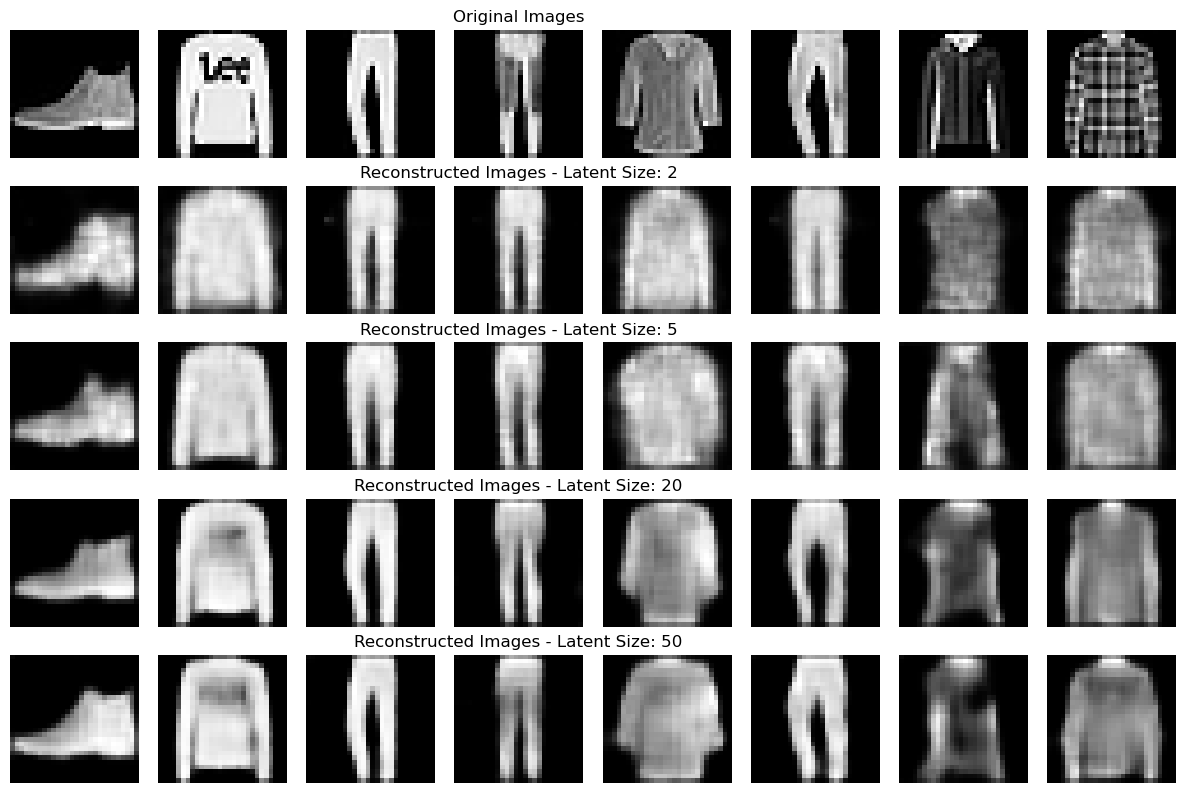

In [184]:
# Get some images from the test dataset
data_iter = iter(faishon_test_dl)
images, _ = next(data_iter)

# Move images to the device
images = images.to(device)

# Pass the images through the autoencoder
fvae_2.eval()
fvae_5.eval()
fvae_20.eval()
fvae_50.eval()
with torch.no_grad():
    reconstructions_2 = fvae_2(images)
    reconstructions_5 = fvae_5(images)
    reconstructions_20 = fvae_20(images)
    reconstructions_50 = fvae_50(images)

# Plot the original and reconstructed images
fig, axes = plt.subplots(5, 8, figsize=(12, 8))

for i in range(8):
    ax = axes[0, i]
    ax.imshow(images[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Original Images')

    ax = axes[1, i]
    ax.imshow(reconstructions_2[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 2')

    ax = axes[2, i]
    ax.imshow(reconstructions_5[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 5')

    ax = axes[3, i]
    ax.imshow(reconstructions_20[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 20')

    ax = axes[4, i]
    ax.imshow(reconstructions_50[i].cpu().squeeze(), cmap='gray')
    ax.axis('off')
    if i == 3:
        ax.set_title('Reconstructed Images - Latent Size: 50')

plt.tight_layout()
plt.show()

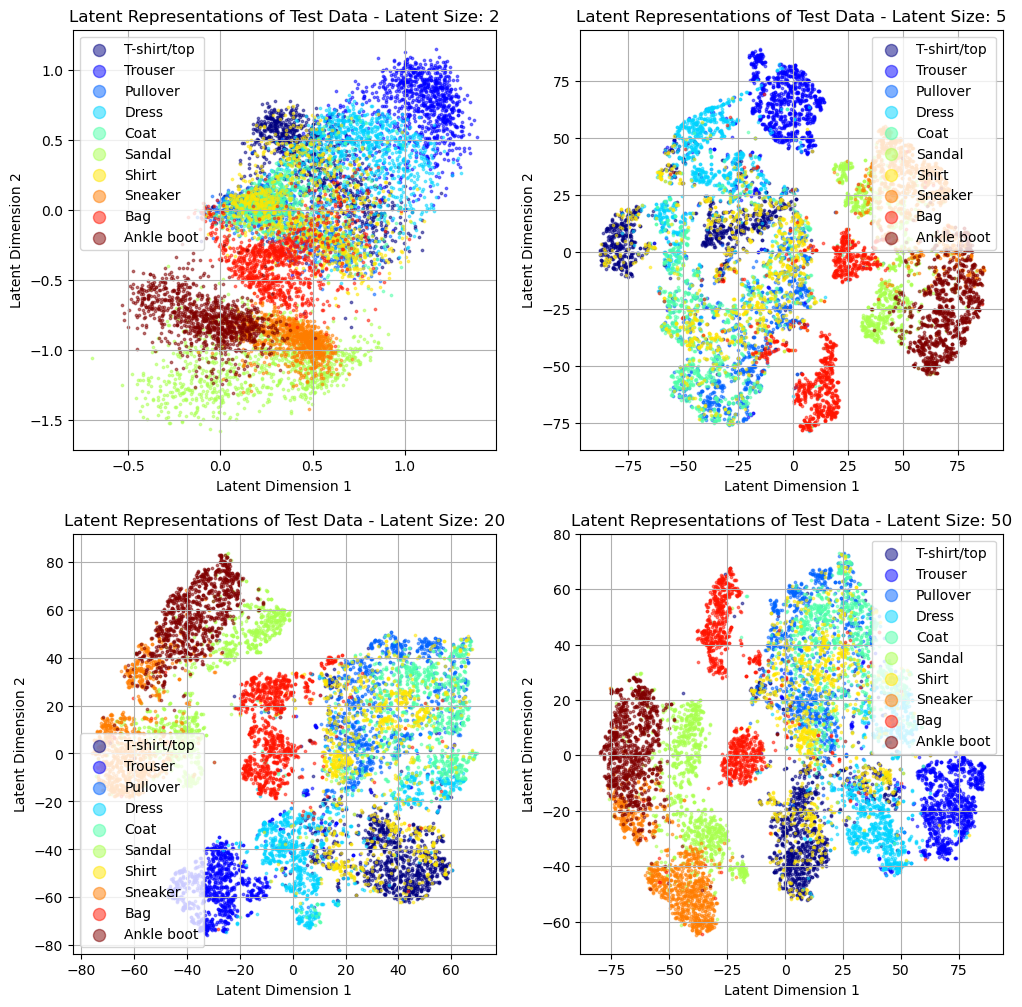

In [186]:
from sklearn.manifold import TSNE

latent_representations_2 = []
latent_representations_5 = []
latent_representations_20 = []
latent_representations_50 = []
labels_agg = []
classes = list(range(10))

faishon_mnist_test_ds.start_return_labels()
test_dl_with_labels = DataLoader(faishon_mnist_test_ds, batch_size=128)

fvae_2.eval()
fvae_5.eval()
fvae_20.eval()
fvae_50.eval()
# Get the latent representations for all test data
with torch.no_grad():
    for images, _, labels in test_dl_with_labels:
        images = images.to(device)
        latent_vectors = fvae_2.encoder(images)
        latent_representations_2.append(latent_vectors.cpu().numpy())
        latent_vectors = fvae_5.encoder(images)
        latent_representations_5.append(latent_vectors.cpu().numpy()) 
        latent_vectors = fvae_20.encoder(images)
        latent_representations_20.append(latent_vectors.cpu().numpy()) 
        latent_vectors = fvae_50.encoder(images)
        latent_representations_50.append(latent_vectors.cpu().numpy()) 
        labels_agg.append(labels.numpy())

# Concatenate all latent representations
latent_representations_2 = np.concatenate(latent_representations_2, axis=0)
latent_representations_5 = np.concatenate(latent_representations_5, axis=0)
latent_representations_20 = np.concatenate(latent_representations_20, axis=0)
latent_representations_50 = np.concatenate(latent_representations_50, axis=0)
labels_agg = np.concatenate(labels_agg, axis=0)

# Plot the latent representations
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
cmap = plt.get_cmap('jet', 10)
for i, (representation, n_dims) in enumerate(zip([latent_representations_2, latent_representations_5, latent_representations_20, latent_representations_50], [2, 5, 20, 50])):
    # Create a 2D representation of the latent space
    if n_dims == 2:
        X_embedded = representation
    else:
        X_embedded = TSNE(n_components=2).fit_transform(representation)

    # Plot the 2D representation
    ax = axes[i // 2, i % 2]
    for c in classes:
        indices = np.where(labels_agg == c)
        
        ax.scatter(
            X_embedded[indices, 0],
            X_embedded[indices, 1],
            s=3,
            label=f"{label_mapper[c]}",
            c=[cmap(c)],
            alpha=0.5,
        )
    ax.legend(markerscale=5)
    ax.set_title(f'Latent Representations of Test Data - Latent Size: {n_dims}')
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.grid(True)
plt.show()